<a href="https://colab.research.google.com/github/smthomas1704/restoration-rag/blob/main/functional_trait_rag_with_jina_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download
Download the zipped literature file from this Google Drive location

In [ ]:
!git clone https://github.com/smthomas1704/restoration-rag.git

!pip install -r restoration-rag/requirements.txt
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4
!pip install gdown==v4.6.3
!pip install openai
!pip install langchain_experimental
!pip install sklearn

# !gdown https://drive.google.com/file/d/10_inKhFuY5O8Sel88ZvlTqODsbbh4ula/view?usp=drive_link -O /content/functional_trait_literature_zipped.zip --fuzzy

# !unzip /content/functional_trait_literature_zipped.zip

# Chunk and store

In this portion, we'll chunk all the files into smaller paragraphs and use that for generating embeddings. We'll separately store the chunks so we can use it later, without having to re-download all the literature again.

### References/Notes related to chunking
1. https://openai.com/blog/new-and-improved-embedding-model
2. text-embedding-ada-002 is the best model for text embedding generation
3. https://www.pinecone.io/learn/chunking-strategies/
4. https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf#using-pypdf

### Possible strategies for chunking
1. LaTex: LaTeX is a document preparation system and markup language often used for academic papers and technical documents. By parsing the LaTeX commands and environments, you can create chunks that respect the logical organization of the content (e.g., sections, subsections, and equations), leading to more accurate and contextually relevant results.
2. Latex taxes a string as input, so we will need to read
3. Most of these academic papers are written in Latex and then converted to PDF. Our best bet would be to convert the PDF to Latex format first and then use the Latex based chunker to chunk things. This way paragraphs and related information will be together and contextualized.
4. On the other hand its not a guarantee that the document was first written in LaTex.

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from huggingface_hub import hf_hub_download
from langchain.docstore.document import Document
import builtins
import pandas as pd
import json

REPO_ID = "collaborativeearth/functional_trait_papers"
FILENAME = "all_afr_carbon_large_chunks.jsonl"

# Download the chunks from Huggingface. We generated the chunks and uploaded it to Huggingface
file_name = hf_hub_download(repo_id=REPO_ID, filename=FILENAME, repo_type="dataset", local_dir="/content/")

print(file_name)
chunks=[]

with open(file_name, "r") as final:
  chunks = json.load(final)

prod_splits=[]

for chunk in chunks:
  print(chunk)
  # try:
  prod_splits.append(Document(
    page_content=chunk['page_content'],
    metadata={
        "source": chunk['title'],
        "id": chunk['id']
    }
  ))
  # except:
  #   print("Exception for chunk:")
  #   print(chunk)

print(prod_splits[0])
print(prod_splits[1])

## Now we will generate embeddings using different models for comparison
First one is jina-embedding-l-en-v1

In [26]:
!mkdir "/content/vectorstore"
DB_JINA_EMBEDDING_PATH = 'vectorstore/db_jina-embedding-l-en-v1'

# Note this transformer version only supports context window of 512
# This is roughyl 384 words. Some of the sentences in our corpus is around
# 650 tokens. These will get truncated. So we should also try this out with
# the smaller embedding size.
embeddings = HuggingFaceEmbeddings(model_name='jinaai/jina-embedding-l-en-v1',
                                       model_kwargs={'device': 'cuda'})

db = FAISS.from_documents(prod_splits, embeddings)
serialized_bytes = db.serialize_to_bytes()
with open("/content/vectorstore/serialized_db.txt", "wb") as binary_file:
    # Write bytes to file
    binary_file.write(serialized_bytes)

db.save_local(DB_JINA_EMBEDDING_PATH)

mkdir: cannot create directory ‘/content/vectorstore’: File exists


Factors explaining variability in woody above-ground biomass accumulation in restored tropical forest


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


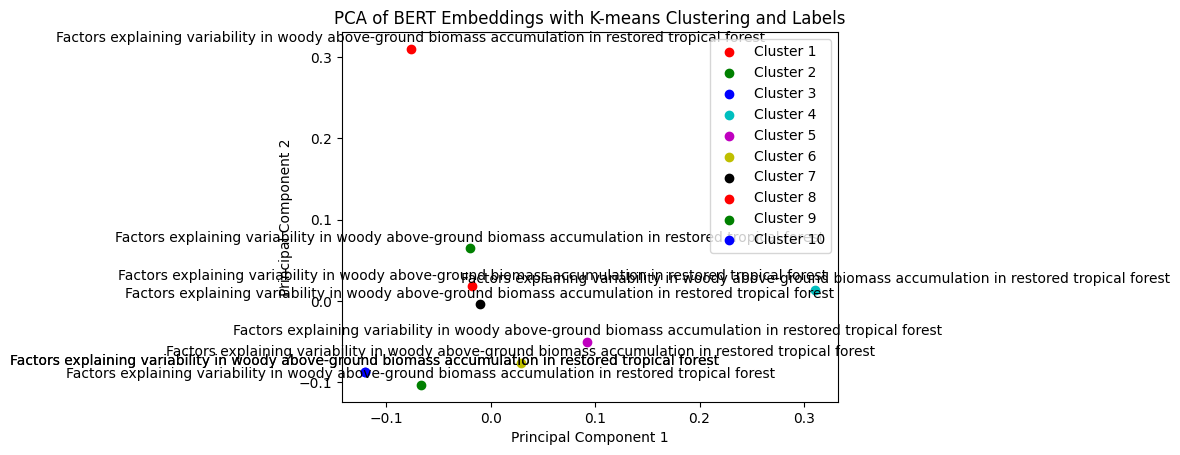

In [25]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

smaller_list = prod_splits[:10]
print(smaller_list[0].metadata['source'])
query_embeddings = embeddings.embed_documents(map(lambda x: x.page_content, smaller_list))

# Perform PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(query_embeddings)

# Perform K-means clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(query_embeddings)

# Plot the clusters in PCA space with labels
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Define colors for up to 7 clusters
for i in range(num_clusters):
    plt.scatter(embeddings_2d[cluster_labels == i, 0], embeddings_2d[cluster_labels == i, 1],
                color=colors[i % len(colors)], label=f'Cluster {i+1}')

# Label each point with the corresponding sentence
for i, sentence in enumerate(smaller_list):
    plt.annotate(sentence.metadata['source'], (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('PCA of BERT Embeddings with K-means Clustering and Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



In [8]:
query = "Give me all the information about reverting abandoned fishponds back to mangrove forests"
docs = await db.asimilarity_search(query, fetch_k=6)
for doc in docs:
  print(doc)

page_content='About 30 years after abandoned fishpond rehabilitation, we found a higher tree density in the mangrove-converted fishponds, presumably due to the strategic inland location of these plantations and silvicultural management immediately after plantation establishment. There were no significant differences found in the vegetation carbon stock, indicating that the kind of species growing in the natural stand (e.g., Avicennia sp.) may have overshadowed the higher tree density at the Rhizophora-dominated reforestation site. A comparable soil C at the reforestation site with that of the natural stand warrants the continuous preservation and restoration of the remaining abandoned aquaculture ponds in the country, not only because they are ecologically and economically important but because of their potential to store huge amounts of carbon that will counterbalance anthropogenic CO 2 emissions.\nThus, the active roles of local communities in rehabilitating vast areas of abandoned f

In [11]:
from google.colab import userdata
from openai import OpenAI
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceInstructEmbeddings
from langchain.vectorstores import FAISS
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain, RetrievalQA
from langchain.indexes import VectorstoreIndexCreator
from langchain_experimental.agents.agent_toolkits.csv.base import create_csv_agent
from langchain.agents.agent_types import AgentType
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate
import tiktoken
import os

OPENAI_API_KEY = userdata.get('COLABORATIVE_EARTH_KEY')
llm_model = "gpt-3.5-turbo"

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

llm = ChatOpenAI(temperature=0.7, model_name="gpt-3.5-turbo")

memory = ConversationBufferMemory(
  memory_key='chat_history',
  return_messages=False
)

retriever = db.as_retriever(
    search_kwargs={"k": 5}
)

custom_template = """You are an AI assistant for assisted restoration papers.
You are given the following extracted parts of a long document.
=========
{context}
=========
Provide a conversational answer for the following question
Question: {question}.
If you don't know the answer, just say "Hmm, I'm not sure." Don't try to make up an answer.
Answer in Markdown:"""


conversation_chain_without_reference = ConversationalRetrievalChain.from_llm(
        llm=llm,
        # chain_type="stuff" will go through everything.
        chain_type="refine",
        # chain_type="stuff",
        retriever=retriever,
        # return_source_documents=True,
        verbose=True,
        memory=memory,
        # combine_docs_chain_kwargs={"question_prompt": custom_prompt, "refine_prompt": custom_prompt}
)

result = conversation_chain_without_reference({"question": query})
answer = result["answer"]

answer



> Entering new RefineDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Context information is below.
------------
About 30 years after abandoned fishpond rehabilitation, we found a higher tree density in the mangrove-converted fishponds, presumably due to the strategic inland location of these plantations and silvicultural management immediately after plantation establishment. There were no significant differences found in the vegetation carbon stock, indicating that the kind of species growing in the natural stand (e.g., Avicennia sp.) may have overshadowed the higher tree density at the Rhizophora-dominated reforestation site. A comparable soil C at the reforestation site with that of the natural stand warrants the continuous preservation and restoration of the remaining abandoned aquaculture ponds in the country, not only because they are ecologically and economically important but because of their potential to store huge amounts of carbon

'The additional context provided underscores the importance of mangrove reforestation in restoring degraded mangrove forests and recovering ecosystem services, such as carbon sequestration. It also highlights the use of litter fall as a proxy for estimating the productivity of restored mangrove ecosystems and emphasizes the need for integrating mangrove reforestation into coastal zone management frameworks for sustainable development in coastal areas.\n\nIn light of this new information, the refined answer should emphasize the significance of utilizing science-based approaches, diverse mangrove species, and integrated coastal zone management strategies in reverting abandoned fishponds back to mangrove forests. It is crucial to highlight the potential role of mangrove reforestation in not only enhancing coastal community livelihoods but also in restoring ecosystem functions, such as carbon sequestration and biodiversity conservation. By emphasizing these points, the benefits and importa

###TODO
1. Add a cross encoder after the retrieval stage to re-rank the results before feeding it to the API.
2. Alternately, or maybe along with this, we may also want to combine several chunks to send as context, depending on the context lenght.
3. Or perhaps we also chunk in small portions and combine results to send to OpenAI. This way answers can be formed based on chunks from different papers and different sections.
4. Update this RAG to cite sources from the context provided. Refence: https://blog.langchain.dev/langchain-chat/

https://towardsdatascience.com/4-ways-of-question-answering-in-langchain-188c6707cc5a